<b>
<p>- 학습 데이터 : 2008년 부터 2021년 까지  6월 1일 부터 9월 30까지</p>
<p>- 테스트 데이터 : 2022년 5월 1일 부터 10월 31일 까지</p>
<p>- 독립 변수 : 기상요소(9개), 세시간전 강수량, 두시간전 강수량, 한시간전 강수량, 현재시간 강수량</p>
<p>- 종속 변수 : 다음 시간 강수량</p></b>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Concatenate, LSTM, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import concatenate                  # 두 출력을 연결

from google.colab import drive                         # 코랩 드라이브와 연동
from sklearn.metrics import mean_absolute_error        # 평균 절대값 에러(모델 평가 지수)
from sklearn.metrics import mean_squared_error         # 평균 제곱근 에러(모델 평가 지수)

from keras.datasets import cifar10


In [2]:
drive.mount('/content/drive')
pathname = '/content/drive/MyDrive/Colab Notebooks/endterm.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv(pathname, encoding = 'utf-8')
print(data.info())         # 데이터 셋 정보보기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33814 entries, 0 to 33813
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기온      33814 non-null  float64
 1   풍속      33814 non-null  float64
 2   습도      33814 non-null  float64
 3   증기압     33814 non-null  float64
 4   이슬점온도   33814 non-null  float64
 5   현지기압    33814 non-null  float64
 6   전운량     33814 non-null  int64  
 7   중하층운량   33814 non-null  int64  
 8   지면온도    33814 non-null  float64
 9   강수량3    33814 non-null  float64
 10  강수량2    33814 non-null  float64
 11  강수량1    33814 non-null  float64
 12  강수량     33814 non-null  float64
 13  강수량_n1  33814 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 3.6 MB
None


In [4]:
data = data.to_numpy()                                       # 리스트를 배열로
data=(data-np.min(data,0))/(np.max(data,0)-np.min(data,0))   # 정규화
print(data[0 : 5])                                           # 샘플보기

[[0.44416244 0.12280702 0.3908046  0.24734043 0.34626866 0.99079026
  0.         0.         0.55495979 0.         0.         0.
  0.         0.        ]
 [0.41116751 0.0877193  0.50574713 0.27659574 0.39402985 0.99088929
  0.         0.         0.5487042  0.         0.         0.
  0.         0.        ]
 [0.39086294 0.16666667 0.52873563 0.27393617 0.3880597  0.9905922
  0.         0.         0.54244861 0.         0.         0.
  0.         0.        ]
 [0.37817259 0.15789474 0.55172414 0.27393617 0.3880597  0.99049317
  0.1        0.         0.53887399 0.         0.         0.
  0.         0.        ]
 [0.3857868  0.18421053 0.51724138 0.26329787 0.37313433 0.9905922
  0.1        0.         0.54334227 0.         0.         0.
  0.         0.        ]]


In [5]:
# 데이터 셋 생성
## 코딩 ################################
# 입력 데이터(마지막 샘플 전까지)
# 타겟(다음 시간 부터 마지막 샘플까지-- 다음 시간 전력량)

x_data = data[ : , : -1 ]


y_data = data[ : , -1]



########################################
# 데이터 셋 스케일 보기
print(x_data.shape)
print(y_data.shape)
print(33814 - 4416)        # 학습 데이터와 테스트 데이터 분할

(33814, 13)
(33814,)
29398


In [6]:
# 학습 데이터 및 테스트 데이터 셋 분할
## 코딩 ################################

x_train = x_data[:29398, :]
y_train = y_data[:29398]

x_test = x_data[29398:, :]
y_test = y_data[29398:]
print(x_train.shape)                    # 데이터 셋 스케일 보기
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# 학습 데이터
# 테스트 데이터
########################################

(29398, 13)
(29398,)
(4416, 13)
(4416,)


1. DNN 모델로 예측하기(keras API)

In [7]:
# DNN 모델 셜계(keras API)
## 코딩 ################################
input = Input(shape=(13,))
hidden1 = Dense(64, activation='relu')(input)
hidden2 = Dense(128, activation='relu')(hidden1)
hidden3 = Dense(256, activation='relu')(hidden2)
hidden4 = Dense(128, activation='relu')(hidden3)
hidden5 = Dense(64, activation='relu')(hidden4)
output = Dense(1, activation='linear')(hidden5)
model_DNN = Model(inputs=input, outputs=output)
########################################
model_DNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65    

In [8]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
model_DNN.compile(loss = 'mse', optimizer = optimizers.Adam(0.005), metrics=['accuracy'])

In [9]:
# DNN 모델 학습
## 코딩 ################################
# 모델 학습

hist = model_DNN.fit(
x_train, y_train,                               # 입력 / 라벨
epochs = 10, batch_size = 64,                   # 학습 회수 / 10개 샘플마다 학습
validation_data=(x_test, y_test),               # 검증 데이터
callbacks = [early_stopping]  # 저장 및 모니터링
)
########################################

Epoch 1/10
460/460 [==============================] - 7s 9ms/step - loss: 0.0011 - accuracy: 0.8888 - val_loss: 9.0737e-04 - val_accuracy: 0.8902
Epoch 2/10
460/460 [==============================] - 5s 10ms/step - loss: 8.7565e-04 - accuracy: 0.8888 - val_loss: 0.0010 - val_accuracy: 0.8902
Epoch 3/10
460/460 [==============================] - 4s 8ms/step - loss: 8.3664e-04 - accuracy: 0.8888 - val_loss: 9.2950e-04 - val_accuracy: 0.8902
Epoch 4/10
460/460 [==============================] - 4s 8ms/step - loss: 8.2401e-04 - accuracy: 0.8888 - val_loss: 8.6847e-04 - val_accuracy: 0.8902
Epoch 5/10
460/460 [==============================] - 3s 6ms/step - loss: 8.1693e-04 - accuracy: 0.8888 - val_loss: 8.8218e-04 - val_accuracy: 0.8902
Epoch 6/10
460/460 [==============================] - 3s 7ms/step - loss: 8.0972e-04 - accuracy: 0.8888 - val_loss: 0.0012 - val_accuracy: 0.8902
Epoch 7/10
460/460 [==============================] - 2s 4ms/step - loss: 8.2812e-04 - accuracy: 0.8888 - val_l

In [10]:
# 예측값
predict = model_DNN.predict(x_test)

# 예측값과 실제갑간의 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

138/138 [==============================] - 0s 2ms/step
0.007965411462232518
0.0008610191219911198
0.029343127338290302


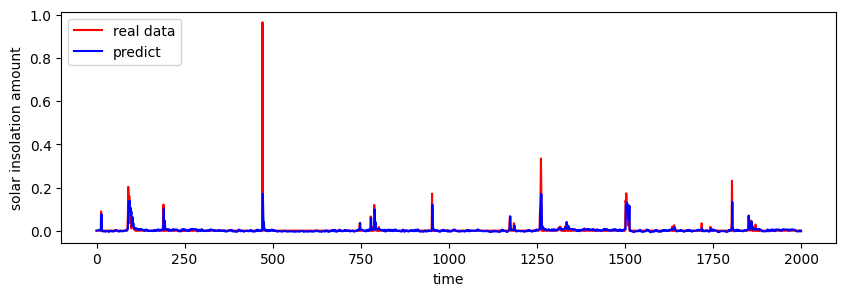

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 2000], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[0 : 2000], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

2. DNN 병렬 모델로 예측하기(keras API)

In [12]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# 첫 번째 입력 정의
input_10 = Input(shape=(13,), name='input_10')
dense_36 = Dense(64, activation='relu')(input_10)
dense_38 = Dense(256, activation='relu')(dense_36)
dense_39 = Dense(16, activation='relu')(dense_38)

# 두 번째 입력 정의
input_11 = Input(shape=(13,), name='input_11')
dense_40 = Dense(256, activation='relu')(input_11)
dense_41 = Dense(128, activation='relu')(dense_40)
dense_42 = Dense(64, activation='relu')(dense_41)
dense_43 = Dense(16, activation='relu')(dense_42)

# 두 경로의 병합
concatenated = Concatenate()([dense_39, dense_43])

dense_44 = Dense(8, activation='relu')(concatenated)
output = Dense(1, activation='linear')(dense_44)


model_DNN = Model(inputs=[input_10, input_11], outputs=output)

# 모델 요약 출력
model_DNN.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 13)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 13)]                 0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 256)                  3584      ['input_11[0][0]']            
                                                                                                  
 dense_6 (Dense)             (None, 64)                   896       ['input_10[0][0]']            
                                                                                            

In [13]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
model_DNN.compile(loss = 'mse', optimizer = optimizers.Adam(0.005), metrics=['accuracy'])

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split

data_poly = []  # 입력 데이터 리스트
y_train_list = []  # 출력 데이터 리스트

# 데이터 준비
for i in range(len(x_data) - 13):
    x = x_data[i: i + 13, :]
    y = y_data[i + 13: i + 14]  # 일관된 형태를 유지하기 위해 단일 요소 추출
    data_poly.append(x)
    y_train_list.append(y)

data_poly = np.array(data_poly)
y_train_array = np.array(y_train_list)



print("data_poly shape:", data_poly.shape)
print("y_train_array shape:", y_train_array.shape)

# 데이터셋 분할
X_train, X_test, Y_train, Y_test = train_test_split(data_poly, y_train_array, test_size=0.2, random_state=42)

# 결과 출력
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


data_poly shape: (33801, 13, 13)
y_train_array shape: (33801,)
X_train shape: (27040, 13, 13)
X_test shape: (6761, 13, 13)
Y_train shape: (27040,)
Y_test shape: (6761,)


In [39]:
# DNN 병렬 모델 학습
## 코딩 ################################
# 모델 학습
hist = model_DNN.fit(
                    [X_train, X_train], Y_train,                               # 입력 / 라벨
                     epochs = 10, batch_size = 64,                   # 학습 회수 / 10개 샘플마다 학습
                     validation_data=([X_test, X_test], Y_test),    # 검증 데이터
                    callbacks=[early_stopping]
                    )
########################################

Epoch 1/10
423/423 [==============================] - 7s 8ms/step - loss: 0.0020 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 2/10
423/423 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 3/10
423/423 [==============================] - 4s 10ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 4/10
423/423 [==============================] - 4s 10ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 5/10
423/423 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 6/10
423/423 [==============================] - 3s 7ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epoch 7/10
423/423 [==============================] - 4s 10ms/step - loss: 0.0011 - accuracy: 0.8894 - val_loss: 0.0013 - val_accuracy: 0.8871
Epo

In [40]:
# 테스트 셋의 특성 값을 입력 하면 예측 값 산출
predict = model_DNN.predict([x_test, x_test])

# 예측값과 실제갑간의 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

138/138 [==============================] - 0s 2ms/step
0.017069075997787547
0.0012507737511138742
0.03536627985968943


3. LSTM 모델로 예측하기(keras API)

In [41]:
x_data = []                         # 입력데이터 리스트
y_data = []                         # 출력데이터 리스트

# LSTM 데이터 셋 만들기
## 코딩 ################################
x_data = []  # 입력 데이터 리스트
y_data = []  # 출력 데이터 리스트

time_steps = 24  # 타임스텝 길이

for i in range(len(data) - time_steps):
    x = data[i:i + time_steps, :-1]  # 마지막 컬럼을 제외한 데이터
    y = data[i + time_steps, -1]  # 예측할 값 (마지막 컬럼)
    x_data.append(x)
    y_data.append(y)

# 리스트를 배열로 변환하기
x_data = np.array(x_data)
y_data = np.array(y_data)




########################################

# 리스트를 배열로 변환하기
x_data = np.array(x_data)
y_data = np.array(y_data)

# 데이터 셋 스케알 보기
print(x_data.shape)
print(y_data.shape)
print(33789 - 4416)

(33790, 24, 13)
(33790,)
29373


In [56]:
# 학습 데이터 및 테스트 데이터 셋 분할
## 코딩 ################################
# 학습 데이터 셋
x_data = []  # 입력 데이터 리스트
y_data = []  # 출력 데이터 리스트

time_steps = 13

for i in range(len(data) - time_steps):
    x = data[i:i + time_steps, :]
    y = data[i + time_steps, :]
    x_data.append(x)
    y_data.append(y)

# 리스트를 배열로 변환하기
x_data = np.array(x_data)
y_data = np.array(y_data)

# 데이터 셋 스케일 확인
print("x_data shape:", x_data.shape)
print("y_data shape:", y_data.shape)

# 데이터셋 분할

X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 결과 출력
# 테스트 데이터 셋
########################################

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

x_data shape: (33801, 13, 14)
y_data shape: (33801, 14)
(29398, 13, 13)
(50000, 1)
(4416, 13)
(10000, 1)


In [57]:

## 코딩 ################################
input_layer = Input(shape=(time_steps, x_data.shape[2]), name='input_12')
lstm_layer = LSTM(64, name='lstm_2')(input_layer)
dense_1 = Dense(64, activation='relu', name='dense_46')(lstm_layer)
output_layer = Dense(1, activation='linear', name='dense_47')(dense_1)

model_LSTM = Model(inputs=input_layer, outputs=output_layer)
########################################
model_LSTM.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 13, 14)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                20224     
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24449 (95.50 KB)
Trainable params: 24449 (95.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
model_LSTM.compile(loss = ' mse', optimizer = optimizers.Adam(0.005), metrics=['accuracy'])

In [59]:
# 모델 학습
## 코딩 ################################

# 모델 학습
hist = model_LSTM.fit(
    X_train, Y_train,  # 입력 / 라벨
    epochs=10, batch_size=64,  # 학습 회수 / 배치 크기
    validation_data=(X_test, Y_test),  # 검증 데이터
    callbacks=[early_stopping]  # 저장 및 모니터링
)
########################################

Epoch 1/10
423/423 [==============================] - 6s 8ms/step - loss: 0.1320 - accuracy: 0.3547 - val_loss: 0.1314 - val_accuracy: 0.3557
Epoch 2/10
423/423 [==============================] - 2s 5ms/step - loss: 0.1312 - accuracy: 0.3558 - val_loss: 0.1314 - val_accuracy: 0.3554
Epoch 3/10
423/423 [==============================] - 2s 5ms/step - loss: 0.1312 - accuracy: 0.3558 - val_loss: 0.1314 - val_accuracy: 0.3557
Epoch 4/10
423/423 [==============================] - 2s 5ms/step - loss: 0.1312 - accuracy: 0.3557 - val_loss: 0.1313 - val_accuracy: 0.3558
Epoch 5/10
423/423 [==============================] - 2s 5ms/step - loss: 0.1311 - accuracy: 0.3556 - val_loss: 0.1312 - val_accuracy: 0.3552
Epoch 6/10
423/423 [==============================] - 3s 7ms/step - loss: 0.1310 - accuracy: 0.3554 - val_loss: 0.1311 - val_accuracy: 0.3557
Epoch 7/10
423/423 [==============================] - 3s 6ms/step - loss: 0.1309 - accuracy: 0.3557 - val_loss: 0.1311 - val_accuracy: 0.3556
Epoch 

In [ ]:
# 테스트 셋의 특성 값을 입력 하면 예측 값 산출
predict = model_LSTM.predict(x_test)

# 예측값과 실제갑간의 오차
mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mse**0.5
print(mae)
print(mse)
print(rmse)

139/139 [==============================] - 1s 2ms/step
0.010224539687679961
0.001080820717916736
0.032875837904405354


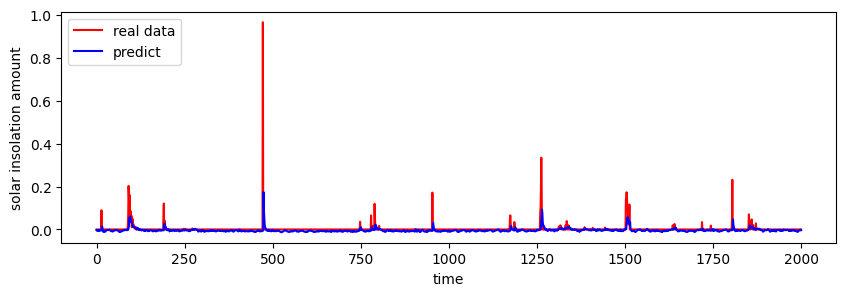

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(y_test[0 : 2000], 'r', label = 'real data')   # 실제값 출력
plt.plot(predict[0 : 2000], 'b', label = 'predict')    # 예측값 출력
plt.xlabel("time")
plt.ylabel("solar insolation amount")
plt.legend(loc='upper left')
plt.show()

4. CNN으로 클래스 예측하기

In [48]:
# Cifar10 데이터 로딩
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [50]:
X_train = X_train/255.0                  # 정규화
X_test = X_test /255.0

In [51]:
Y_train = to_categorical(y_train)        # 원핫 인코딩
Y_test = to_categorical(y_test)
print(Y_train.shape)
print(Y_test.shape)

(50000, 10)
(10000, 10)


In [52]:
# CNN 모델 설계
## 코딩 ################################
input_layer = Input(shape=(32, 32, 3), name='input_14')

conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_24')(input_layer)
conv2 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_25')(conv1)
conv3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_26')(conv2)
pool1 = MaxPooling2D((2, 2), name='max_pooling2d_9')(conv3)

conv4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_27')(pool1)
conv5 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_28')(conv4)
pool2 = MaxPooling2D((2, 2), name='max_pooling2d_10')(conv5)

conv6 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_29')(pool2)
pool3 = MaxPooling2D((2, 2), name='max_pooling2d_11')(conv6)

conv7 = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_30')(pool3)
conv8 = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv2d_31')(conv7)

flatten = Flatten(name='flatten_3')(conv8)
dense1 = Dense(256, activation='relu', name='dense_50')(flatten)
output_layer = Dense(10, activation='softmax', name='dense_51')(dense1)

model = Model(inputs=input_layer, outputs=output_layer)

########################################

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        18496     
                                                           

In [53]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.001), metrics=['accuracy'])

In [54]:
# 모델 학습
## 코딩 ################################
hist = model.fit(
    X_train, Y_train,  # 입력 / 라벨
    epochs=10, batch_size=64,  # 학습 회수 / 배치 크기
    validation_data=(X_test, Y_test),  # 검증 데이터
    callbacks=[early_stopping]  # 저장 및 모니터링
)
########################################

Epoch 1/10
782/782 [==============================] - 16s 13ms/step - loss: 1.5707 - accuracy: 0.4146 - val_loss: 1.3041 - val_accuracy: 0.5320
Epoch 2/10
782/782 [==============================] - 8s 10ms/step - loss: 1.0444 - accuracy: 0.6251 - val_loss: 0.9770 - val_accuracy: 0.6559
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 0.8026 - accuracy: 0.7160 - val_loss: 0.8366 - val_accuracy: 0.7123
Epoch 4/10
782/782 [==============================] - 9s 11ms/step - loss: 0.6454 - accuracy: 0.7745 - val_loss: 0.7290 - val_accuracy: 0.7546
Epoch 5/10
782/782 [==============================] - 12s 15ms/step - loss: 0.5236 - accuracy: 0.8146 - val_loss: 0.7180 - val_accuracy: 0.7645
Epoch 6/10
782/782 [==============================] - 9s 11ms/step - loss: 0.4248 - accuracy: 0.8500 - val_loss: 0.7357 - val_accuracy: 0.7644
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.3379 - accuracy: 0.8802 - val_loss: 0.8045 - val_accuracy: 0.75

In [55]:
# 테스트 데이터로 정확도 측정하기
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('test_acc: ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.7888 - accuracy: 0.7735
test_acc:  0.7735000252723694
